Uses envelope data to predict number of terms needed in each region.

In [1]:
import sys
from pathlib import Path
HERE = Path.cwd().resolve()
up1_path = str((HERE / ".." ).resolve())
up2_path = str((HERE / ".." / ".." ).resolve())
for pathstr in [up1_path, up2_path]:
  if pathstr not in sys.path:
      sys.path.insert(0, pathstr)

from helpers import *
import numpy as np

In [2]:
file1 = "innermost-region/data/predetermined-8.pkl"
file2 = "middle-region/data/predetermined-4.pkl"
file3 = "outermost-region/data/predetermined-2.pkl"

f1_data = open_pkl_file(file1)
for pset in f1_data:
  generate_convergence_data(pset, [0.01])
  generate_log_data(pset)

In [3]:
def innermost_vars(h, d, a, m0): # predicts terms needed in innermost region
  return {"(h-d)/radwidth" : (h-d[0])/a[0],
          "(h-d_out)/(h-d)" : (h-d[1])/(h-d[0]),
          "radwidth/dist_to_e" : a[0]/(a[-1]-a[0]),
          "m0 * dist_to_e" : m0 * (a[-1]-a[0])}

def middle_vars(h, d, a, m0, i): # predicts terms needed in middle region i
  return {"(h-d)/radwidth" : (h-d[i])/(a[i] - a[i-1]),
          "(h-d_out)/(h-d)" : (h-d[i+1])/(h-d[i]),
          "(h-d_in)/(h-d)" : (h-d[i-1])/(h-d[i]),
          "radwidth/dist_to_e" : (a[i] - a[i-1])/(a[-1]-a[i]),
          "radwidth/dist_to_c" : (a[i] - a[i-1])/a[i-1],
          "m0 * dist_to_e" : m0 * (a[-1]-a[i])}

def outermost_vars(h, d, a, m0): # predicts terms needed in middle region i
  return {"(h-d)/radwidth" : (h-d[-1])/(a[-1] - a[-2]),
          "h/(h-d)" : h/(h-d[-1]),
          "(h-d_in)/(h-d)" : (h-d[-2])/(h-d[-1]),
          "radwidth/dist_to_c" : (a[-1] - a[-2])/a[-2],
          "m0h" : m0 * h}

innermost_vars_cf = lambda cf, m0 : innermost_vars(cf["h"], cf["d"], cf["a"], m0)
middle_vars_cf = lambda cf, m0, region : middle_vars(cf["h"], cf["d"], cf["a"], m0, region)
outermost_vars_cf = lambda cf, m0 : outermost_vars(cf["h"], cf["d"], cf["a"], m0)

In [4]:
def unshielded(cf):
  if len(cf["d"]) < 3: return True
  for i in range(2, len(cf["d"])):
    if (cf["h"] - cf["d"][i]) < (cf["h"] - cf["d"][1]): return False
  return True

def filter_unshielded(cfs):
  return [cf for cf in cfs if unshielded(cf)]

def filter_converged(cfs):
  return [cf for cf in cfs if (max(cf[cf["m0s"][0]]["convergence point 0.01 am"],  cf[cf["m0s"][0]]["convergence point 0.01 dp"]) < 150)]

In [47]:
# function fits

# hmdr (both) - alpha independence, beta is a line through the origin
# right ratio - alpha independence, beta is step function
def inner_am_model1(vars, alpha, lower_slope, upper_slope):
  nmk, hmdr, right_ratio, rad_ratio, m0_dist = vars
  offset = upper_slope - lower_slope
  beta = hmdr * (lower_slope + offset * (right_ratio > 1))
  return - alpha * np.log(nmk/beta)

def ab_inner_am_model1(cf, m0, alpha, lower_slope, upper_slope):
  vals = innermost_vars_cf(cf, m0)
  offset = upper_slope - lower_slope
  beta = vals["(h-d)/radwidth"] * (lower_slope + offset * (vals["(h-d_out)/(h-d)"] > 1))
  return alpha, beta

def inner_am_model2(vars, alpha, lower_slope, upper_slope, mult, k):
  nmk, hmdr, right_ratio, rad_ratio, m0_dist = vars
  offset = upper_slope - lower_slope
  beta = hmdr * (lower_slope + offset * (right_ratio > 1)) * (1 - mult * np.exp(- k * rad_ratio))
  return - alpha * np.log(nmk/beta)

def fit_inner_model(cfs, hydro, model, guess, nmk_max = 150):
  xs = [[], [], [], [], []]
  ys = []
  for cf in cfs:
    for m0 in cf["m0s"]:
      vals = innermost_vars_cf(cf, m0)
      for nmk in range(nmk_max):
        xs[0].append(nmk + 1)
        xs[1].append(vals["(h-d)/radwidth"])
        xs[2].append(vals["(h-d_out)/(h-d)"])
        xs[3].append(vals["radwidth/dist_to_e"])
        xs[4].append(vals["m0 * dist_to_e"])
        ys.append(cf[m0]["log errors " + hydro][nmk])
  popt, pcov = curve_fit(model, xs, ys, p0=guess)
  return popt, pcov

In [26]:
file4 = "innermost-region/data/predetermined-2.pkl"
file5 = "innermost-region/data/predetermined-5.pkl"
file6 = "innermost-region/data/predetermined-6.pkl"
file7 = "innermost-region/data/random-innermost.pkl"
f4_data = open_pkl_file(file4)
f5_data = [filter_unshielded(cfs) for cfs in open_pkl_file(file5)]
f6_data = [filter_unshielded(cfs) for cfs in open_pkl_file(file6)]
generate_convergence_data(f4_data, [0.01])
generate_log_data(f4_data)
for pset in f5_data:
  generate_convergence_data(pset, [0.01])
  generate_log_data(pset)
for pset in f6_data:
  generate_convergence_data(pset, [0.01])
  generate_log_data(pset)

f7_data = open_pkl_file(file7)
generate_convergence_data(f7_data, [0.01])
f7_data = filter_unshielded(filter_converged(f7_data))
_ = generate_log_data(f7_data)

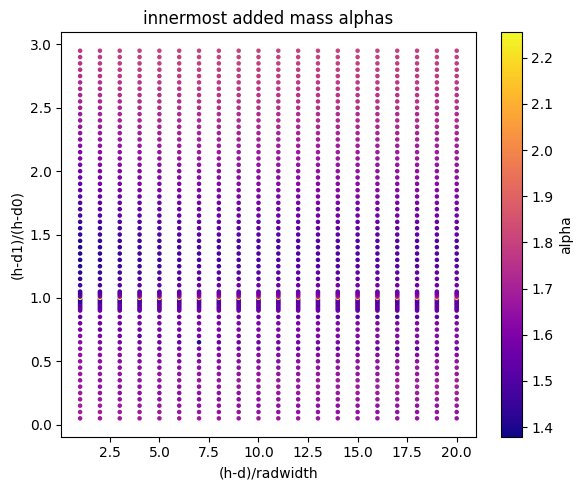

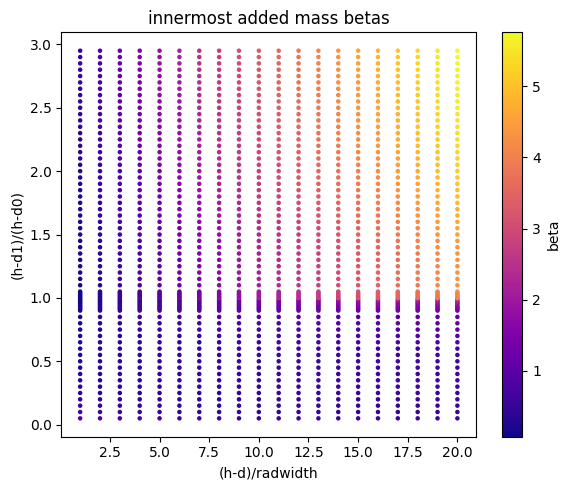

In [34]:
xs, ys, alphas, betas = [], [], [], []

for cf in f4_data:
  popt, pcov, r2_val, r2_under = fit_parameters(cf, cf["m0s"][0], "am", print_params = False)
  alpha, beta = popt
  xs.append((cf["h"] - cf["d"][0])/cf["a"][0])
  ys.append((cf["h"] - cf["d"][1])/(cf["h"] - cf["d"][0]))
  alphas.append(alpha)
  betas.append(beta)

plot_3tuples_2d(np.column_stack((xs, ys, alphas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "alpha", title = "innermost added mass alphas")
plot_3tuples_2d(np.column_stack((xs, ys, betas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "beta", title = "innermost added mass betas")

In [36]:
def fit_and_print(data, model, guess):
  popt, pcov = fit_inner_model(data, "am", model, guess, nmk_max = 150)
  print(popt)
#  print(pcov)

def fit_and_print1(data):
  fit_and_print(data, inner_am_model1, (1.5, 0.02, 0.2))

def fit_and_print2(data):
  fit_and_print(data, inner_am_model2, (1.5, 0.02, 0.2, 0.02, 1))

fit_and_print1(f1_data[1] + f1_data[2] + f1_data[4])
# fit_and_print1(f1_data[1] + f1_data[2])
# fit_and_print1(f1_data[1] + f1_data[4])
# fit_and_print1(f1_data[2] + f1_data[4])
fit_and_print1(f4_data)
fit_and_print1(f5_data[3])
fit_and_print1(f6_data[0] + f6_data[1] + f6_data[2])
fit_and_print1(f7_data[:28] + f7_data[29:]) # what's up with this? maybe generation was bad
print("trying to compensate for the differences is difficult — see model 2")

# fit_and_print2(f1_data[1] + f1_data[2] + f1_data[4])
# fit_and_print2(f4_data)
# fit_and_print2(f5_data[3])
# fit_and_print2(f6_data[0] + f6_data[1] + f6_data[2])
# fit_and_print2(f1_data[1] + f1_data[2] + f4_data + f5_data[3] + f6_data[0] + f6_data[1] + f6_data[2])

[1.49434523 0.03601837 0.20463309]
[1.43608401 0.05081444 0.17027431]
[1.55388509 0.07761913 0.20588457]
[1.5540521  0.0771155  0.20487506]
[1.05220851e+00 1.00387883e-03 6.56617014e-02]
trying to compensate for the differences is difficult — see model 2


In [92]:
def inner_dp_model1(vars, alpha_base, alpha_high, lower_slope, upper_slope):
  nmk, hmdr, right_ratio, rad_ratio, m0_dist = vars
  offset = upper_slope - lower_slope
  alpha_offset = alpha_high - alpha_base
  beta = hmdr * (lower_slope + offset * (right_ratio > 1))
  alpha = alpha_base + alpha_offset * (right_ratio < 1)
  return - alpha * np.log(nmk/beta)

def fit_and_print(data, model, guess):
  popt, pcov = fit_inner_model(data, "dp", model, guess, nmk_max = 150)
  print(popt)
#  print(pcov)

def fit_and_print1(data):
  fit_and_print(data, inner_dp_model1, (1.5, -0.015, 0.025, 0.05))

fit_and_print1(f1_data[1] + f1_data[2] + f1_data[4])

[2.49090716e+00 1.05594004e+00 1.62383570e-04 1.58676033e-01]


In [37]:
fit_and_print1(f7_data[:28] + f7_data[29:])

[1.05220851e+00 1.00387883e-03 6.56617014e-02]


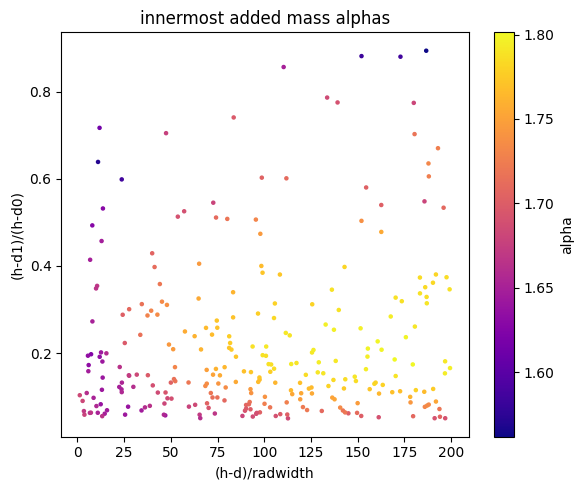

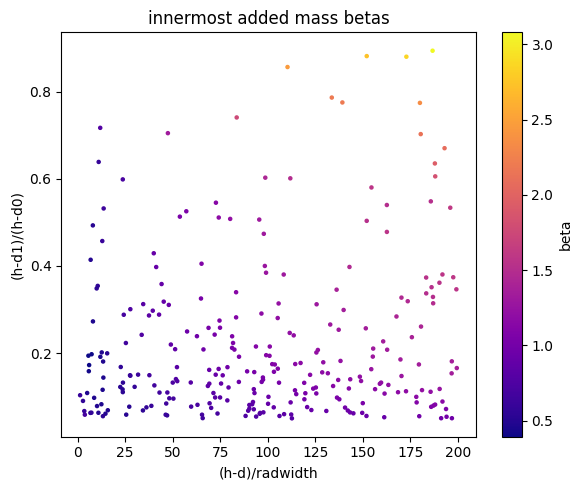

In [46]:
xs, ys, alphas, betas = [], [], [], []

for cf in (f7_data[:28] + f7_data[29:]):
  popt, pcov, r2_val, r2_under = fit_parameters(cf, cf["m0s"][0], "am", print_params = False)
  alpha, beta = popt
  if beta < 4:
    xs.append((cf["h"] - cf["d"][0])/cf["a"][0])
    ys.append((cf["h"] - cf["d"][1])/(cf["h"] - cf["d"][0]))
    alphas.append(alpha)
    betas.append(beta)

plot_3tuples_2d(np.column_stack((xs, ys, alphas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "alpha", title = "innermost added mass alphas")
plot_3tuples_2d(np.column_stack((xs, ys, betas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "beta", title = "innermost added mass betas")

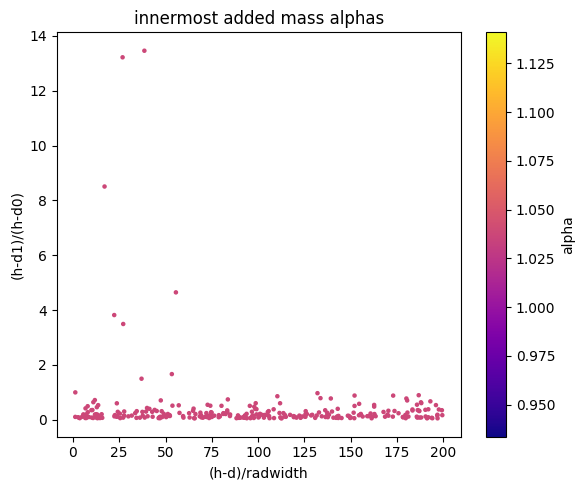

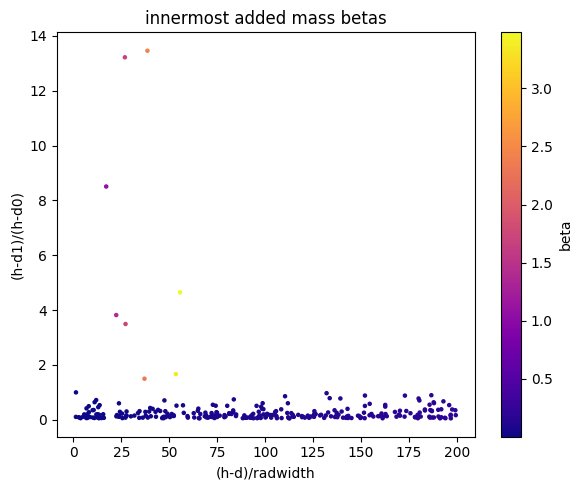

In [48]:
popt, pcov = fit_inner_model(f7_data, "am", inner_am_model1, (1.5, 0.02, 0.2), nmk_max = 150)
params = [ab_inner_am_model1(cf, cf["m0s"][0], *popt) for cf in f7_data]
xs = [(cf["h"] - cf["d"][0])/cf["a"][0] for cf in f7_data]
ys = [(cf["h"] - cf["d"][1])/(cf["h"] - cf["d"][0]) for cf in f7_data]
alphas = [entry[0] for entry in params]
betas = [entry[1] for entry in params]

plot_3tuples_2d(np.column_stack((xs, ys, alphas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "alpha", title = "innermost added mass alphas")
plot_3tuples_2d(np.column_stack((xs, ys, betas)), xlabel = "(h-d)/radwidth", ylabel = "(h-d1)/(h-d0)", clabel = "beta", title = "innermost added mass betas")

In [27]:
xs = list(range(len(f7_data)))
ys = [fit_parameters(cf, cf["m0s"][0], "am", plot_comparison = False, print_params = False)[0] for cf in f7_data]
ys1 = [entry[0] for entry in ys]
ys2 = [entry[1] for entry in ys]
low_alphas = [idx for idx in range(len(ys1)) if ys1[idx] < 1.4]
high_betas = [idx for idx in range(len(ys2)) if ys2[idx] > 3]

In [28]:
print(low_alphas)
print(high_betas)

[28]
[0, 1, 10, 27, 29, 83, 141, 226, 227, 228]


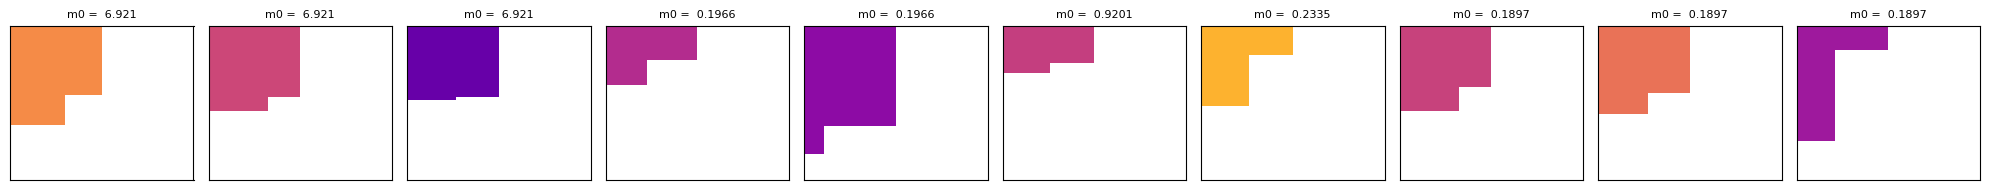

In [29]:
first_m0_filter_and_plot_shapes([f7_data[idx] for idx in high_betas], lambda a, b : True,
                                lambda cf, m0: get_plasma_color(fit_parameters(cf, cf["m0s"][0], "am", plot_comparison = False, print_params = False)[0][1],
                                                                min_value = 0, max_value = 16),
                                ppr = 10, figsize_per_plot = (2, 2))

Best-fit parameters: [ 1.55241323 11.51491687]


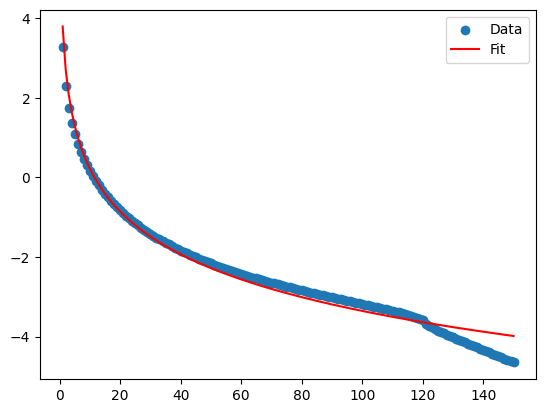

Best-fit parameters: [1.53328185 8.02791552]


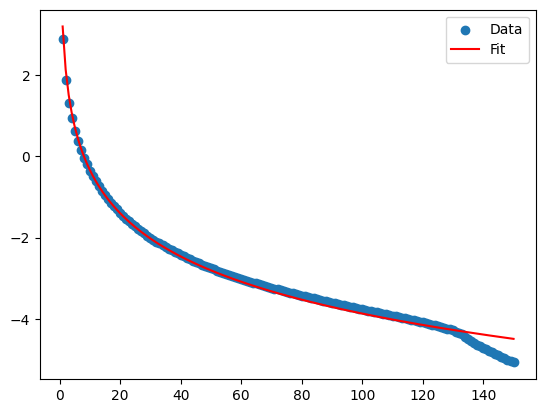

Best-fit parameters: [1.5617128  3.07965125]


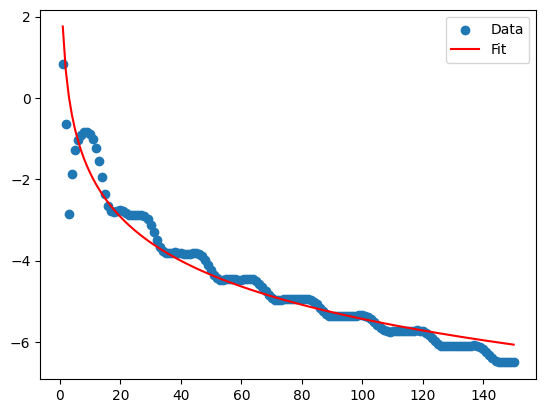

Best-fit parameters: [1.85891386 6.51671192]


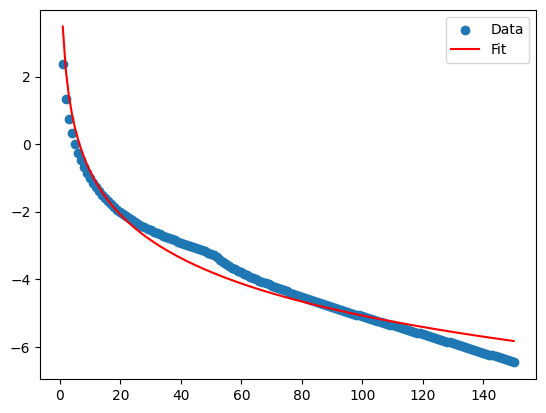

Best-fit parameters: [1.49972308 4.62920697]


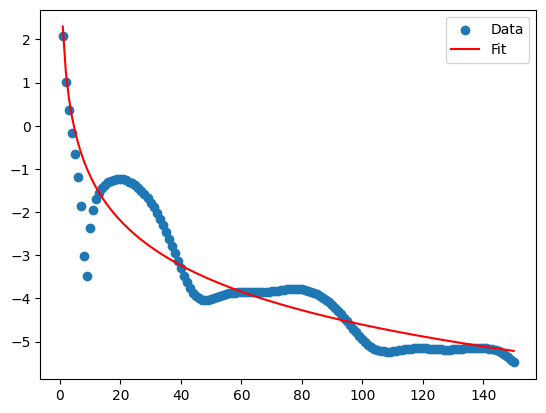

Best-fit parameters: [1.82435324 7.50247284]


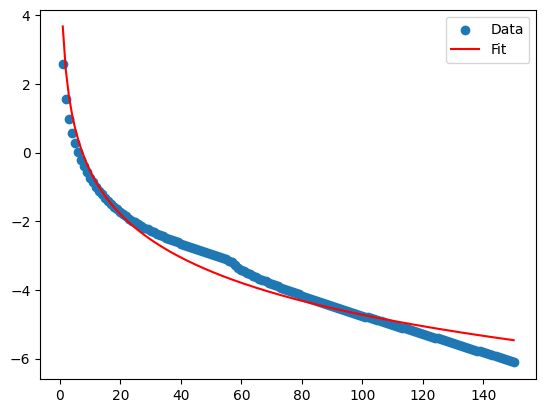

Best-fit parameters: [ 1.7878093  13.25822275]


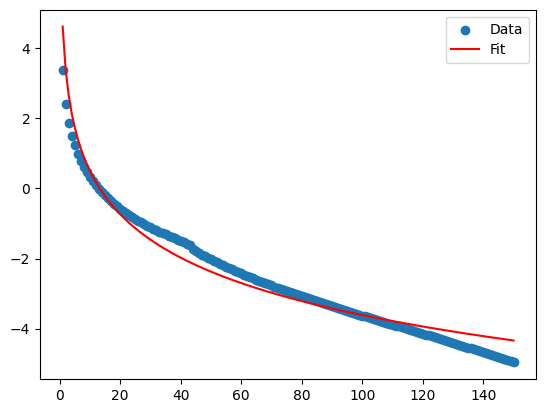

Best-fit parameters: [1.97983438 7.69022217]


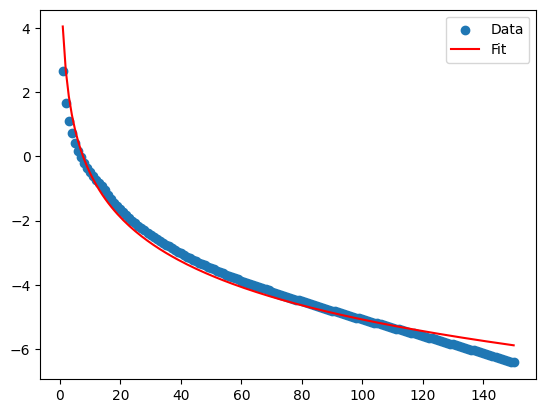

Best-fit parameters: [ 1.91455861 10.32232859]


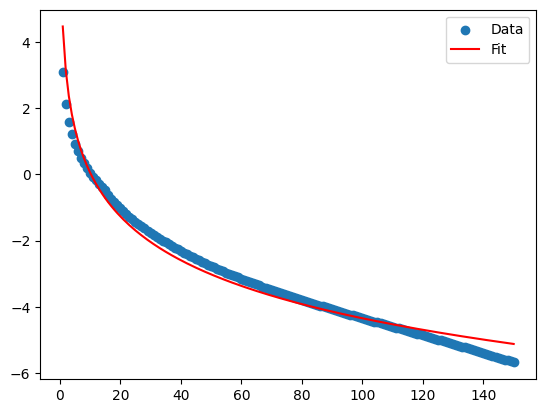

Best-fit parameters: [2.00992028 5.48749181]


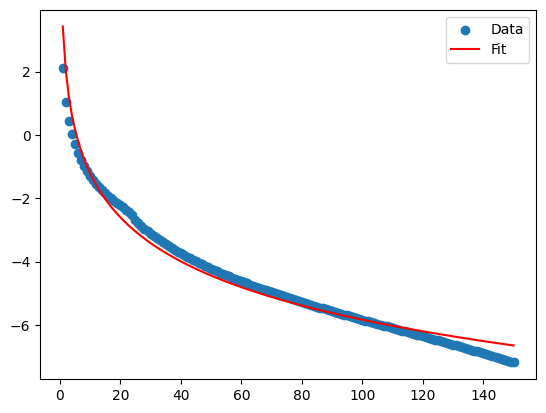

In [30]:
for idx in high_betas:
  cf = f7_data[idx]
  fit_parameters(cf, cf["m0s"][0], "am", plot_comparison = True, print_params = True)

Best-fit parameters: [0.88034591 0.00147605]


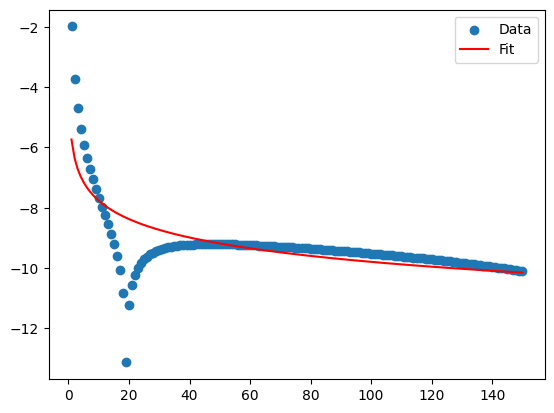

(array([0.88034591, 0.00147605]),
 array([[5.01534104e-03, 8.87313662e-05],
        [8.87313662e-05, 1.58233611e-06]]),
 np.float64(0.5107884777316976),
 np.float64(-1.3455341739931765))

In [31]:
cf = f7_data[28]
fit_parameters(cf, cf["m0s"][0], "am", plot_comparison = True, print_params = True)

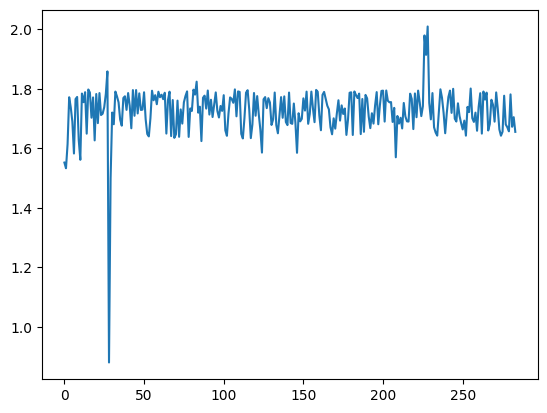

In [32]:
plt.plot(xs, ys1)

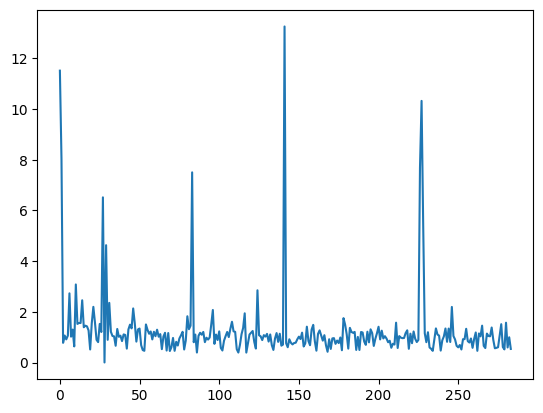

In [33]:
plt.plot(xs, ys2)